# Initial Steps: load packages, files and functions

In [8]:
import pandas as pd
import urllib
import time
import requests
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [9]:
cwd=os.getcwd()
cwd_Raw_Data_outputs=os.path.join(cwd,'RawData')#heres where we store freezes of the raw data
cwd_Figures=os.path.join(cwd,'Figures')#figures and code for generating them can go here
cwd_Output=os.path.join(cwd,'Output Dataframes')

In [10]:
dfSynonym=pd.read_excel(os.path.join(cwd,'Synonyms_filtered_v3.xlsx'),engine="openpyxl")
dfSynonym=dfSynonym.sort_values(by="Symbol")
dfSynonym=dfSynonym.reset_index()
dfSynonym=dfSynonym.drop(columns="index")
dfSynonym.index=dfSynonym["Symbol"]

In [11]:
gene_terms=str("(\"+_gene_+\"[ti])")
CT1_queryPM=str("")
CT1_queryNIH=str("")

In [12]:
def GetAwardAmount(input_String, Lists):
    #function takes three arguments; the Reporter output, the destination where we store results, and an additional list for storing a freeze of the data
    GetResults = input_String.find("\"results\"") #find the part of the output detailing grant award amount, found after the "results" block of the ouput
    
    ResultsList = input_String[GetResults:].replace("},", "")# each grant's information is separated by curly brackets; splitting along curly brackets divides info from each grant
    ResultsList = (ResultsList.split("{\""))[1:]    #saving the individual grant amount as a an element in a list of grants
    for iGrant in ResultsList:# for each grant returned by the query
        Award_Start = iGrant.find("\"award_amount\":")#find the part detailing award amount
        Award_End = iGrant.find("\"project_start_date\":")#find the part that comes after the award amount
        DirectCost = iGrant.find("\"direct_cost_amt\":")
        direct_End = iGrant.find("\"indirect_cost_amt\":")
        Award_string = iGrant[Award_Start:Award_End].replace(",", "").split(":")[1]# the amount of money for grant will be between the part addressed as award amount and the direct cost amount
        try:
            directCost = iGrant[DirectCost:direct_End].replace(",", "").split(':', 1)[1]
            indirectCost = iGrant[direct_End:].replace(",", "").split(':', 1)[1]
        except:
            print("COST ERROR")
            indirectCost=0
            print(iGrant)
            print(input_String)
        if not Award_string == "null": # for some reason, some grants do not have an award amount stored in NIH Reporter
            Lists[0] = Lists[0] + int(Award_string)
            if not directCost == "null":
                Lists[1]=Lists[1]+int(directCost)
            if not "null" in indirectCost:
                indirectCost=indirectCost.replace("}]}","")
                Lists[2]=Lists[2]+int(indirectCost)
    return Lists

In [13]:
"""
This is the main function for pulling data from both PubMed and NIH RePORTER
The function takes 7 arguments; 
the dataframe where data is stored at the end, the url for accessing PubMed, the NIH search parameters in JSON format, and the destination for all Raw data
this function is used for any searches that include grants and publications searches for both title and title/abstract, and all relevant synonyms
returns a dataframe with all the relevant data obtained during the search
The structure of other blocks mimic this almost exactly save some additional tweaks where needed
"""
def AccessPubMed_and_Reporter_Master_function(OutputDF,PubMedUrl,NIH_param,PM_title_raw,PM_tiab_raw,NIH_title_raw,NIH_tiab_raw):
    #Step 1:preliminary steps
    
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    CT1_queryNIH=str("")
    frontParticiple=str(NIH_param["criteria"]["advanced_text_search"]['search_text'])
    for i in dfSynonym.index:
        print(i)
    #Step 2: construct gene search with synonyms
        Excluded=False
        term = gene_terms.replace("_gene_", str(i))
        if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
            CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
            CT1_queryNIH = str(CT1_queryNIH) + "(" + "\"" + str(i) + "\" "
        else: #if the main gene name is something from exclude list, we take its first synonym
            Excluded=True
        Synonym_string=""
        if not isinstance(dfSynonym.loc[i]["Synonyms"],float):  # first check if a list of synonyms exists. if there are no synonyms, value is nan, Nan values are expressed as a float
            CT1_queryPM = str(CT1_queryPM) + str("+OR+")
            CT1_queryNIH = str(CT1_queryNIH) + str(" OR ")
            if "|" in str(dfSynonym.loc[i]["Synonyms"]):  # if multiple terms are included, they will be separated by "|" character, so if character is in list of synonyms, means there are multiple synonyms
                Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")  # split terms into list
                for x in Synonyms_list:  # add each item from list as an additional term to query, formatting the term appropriately
                    if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                        igene_term = gene_terms.replace("_gene_", str(x))
                        Synonym_string=Synonym_string+str(x)+str("|")
                        CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                        CT1_queryNIH = str(CT1_queryNIH) + "\"" + str(x) + "\"" + str(" OR ")
                    #else:
                        #print("excluded: ",x)
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                CT1_queryNIH = CT1_queryNIH[:(len(CT1_queryNIH)) - 4] + str(")")
            else:  # if "|" character is not present but list of synonyms is not null, then there is just one synonymous term
                if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):# add single synonym in the same format as above
                    Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                    igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                    CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                    CT1_queryNIH = CT1_queryNIH + str("\"" + dfSynonym.loc[i]["Synonyms"] + "\"") + str(" OR ")
                    CT1_queryNIH = str(CT1_queryNIH[:(len(CT1_queryNIH)) - 4]) + str(")")
                #else:
                    #print("excluded: ",str(dfSynonym.loc[i]["Removed Synonyms"]))
        else:# same as above, but for genes with no synonyms, just close the parentheses
            CT1_queryPM = str(CT1_queryPM) + str(")")
            CT1_queryNIH = str(CT1_queryNIH) + str(")")
        if Excluded==True:
            CT1_queryPM ="("+ str(CT1_queryPM[4:])
            CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
            Excluded==False
        #Step 3: Perform PubMed publication searches for title and title/abstract
        url_Pubmed_title = PubMedUrl.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
        url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
        PubTitleFreeze = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title.txt')
        if os.path.exists(PubTitleFreeze):
            file1 = open(PubTitleFreeze,'r',encoding="utf-8")
            data_title = file1.readlines()
            for line in data_title:
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            file1.close()
        else:
            data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
            with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
                for line in data_title:
                    f.write(str(line))  # write a freeze of the data from the page
                    f.write('\n')
                    if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                        get_count = str(line).split("Count>")
                        title_count = int(get_count[1].replace("</", ""))
                f.write('\n')
                f.write("url used for search:")
                f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
                f.write('\n')
                f.write("date accessed:")
                GetDate = str(datetime.now())
                f.write(GetDate)
                f.close()
                time.sleep(1)
        url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
        PubTiabFreeze = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab.txt')
        if os.path.exists(PubTiabFreeze):
            file2 = open(PubTiabFreeze,'r',encoding="utf-8")
            data_tiab = file2.readlines()
            for line in data_tiab:
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            file2.close()
        else:   
            data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
            with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
                for line in data_tiab:
                    f.write(str(line))  # write a freeze of the data from the page
                    f.write('\n')
                    if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                        get_count = str(line).split("Count>")
                        tiab_count = int(get_count[1].replace("</", ""))
                f.write('\n')
                f.write("url used for search:")
                f.write(url_tiab)  # store the freeze and search URL as a txt file
                f.write('\n')
                f.write("date accessed:")
                GetDate = str(datetime.now())
                f.write(GetDate)
                f.close()
                time.sleep(1)
        if (CT1_queryNIH[-3:]=="OR "):
            CT1_queryNIH=CT1_queryNIH[:-3]+(")")
        #Step 4: Perform NIH title and title/abstract searches    
        offset = 0
        paramsPlus = NIH_param #define search parameters JSON for RePORTER searches
        paramsPlus["criteria"]["advanced_text_search"]["search_field"]="projecttitle,abstracttext"#first we do title/abstract search
        paramsPlus["criteria"]["advanced_text_search"]['search_text']=frontParticiple+str(CT1_queryNIH)#add the list of genes to the JSON template
        paramsPlus["offset"]=offset
        print(paramsPlus)
        NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_tiab_raw + str(i) + '_NIH_tiab.txt')
        NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_title_raw + str(i) + '_NIH_title.txt')
        fileFound=False
        if os.path.exists(NIH_Raw_tiab):
            file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
            lines3 = file3.readlines()
            JSON_output=lines3[0]
            GetSearchNumber=0
            fileFound=True
        else:
            response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
            JSON_output = response.text  # load JSON, get results in sets of 500
            file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
            file3.writelines(JSON_output)
        if i =="EGFR":
            print(JSON_output)
            
        Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
        Amount_End = JSON_output.find("\"offset\":")
        Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
        Grants = int(Amount[1])
        Award = 0
        Costs_list = [0,0,0]
        if Grants >= 1:  # if there are grants for the gene,
            if Grants < 500:  # if there are less than 500 grants, we only need 1 search
                try:
                    Costs_list = GetAwardAmount(JSON_output, Costs_list)
                except:
                    print(i)
                    print("less than 500 error")
                    break
            else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
                Costs_list = GetAwardAmount(JSON_output, Costs_list)
                GrantsLeft = Grants
                while GrantsLeft > 0:
                    if GrantsLeft > 500:
                        GrantsLeft -= 500
                        if fileFound==True:
                            try:
                                GetSearchNumber+=1
                                JSON_output_offset=lines3[GetSearchNumber]
                            except:
                                print(i)
                                print("excpetion occured, check NIH outputs for full reading")
                                GetSearchNumber+=1
                        else:
                            time.sleep(3)
                            offset += 500
                            paramsPlus2 = paramsPlus
                            paramsPlus2["offset"] = offset
                            response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                            JSON_output_offset = response_plus.text
                            file3.write("\n")
                            file3.writelines(JSON_output_offset)
                        Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                    else:
                        GrantsLeft = 0
        if fileFound==False:
            file3.write("\n")
            file3.write("Date accessed:")
            GetDate = str(datetime.now())
            file3.write(GetDate)
            file3.close()
        Award =int(Costs_list[0])
        time.sleep(1)
        offset = 0
        paramsPlus_Title = paramsPlus #same format as title/abstract JSON, only with "abstracttext" removed from search_field
        paramsPlus_Title["criteria"]["advanced_text_search"]["search_field"]="projecttitle"
        paramsPlus_Title["offset"]=offset
        fileFound_Title=False
        if os.path.exists(NIH_Raw_title):
            file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
            lines4 = file4.readlines()
            JSON_output_Title=lines4[0]
            GetSearchNumber_title=0
            fileFound_Title=True
        else:
            response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
            JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
            file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
            file4.writelines(JSON_output_Title)
        Amount_Start_Title = JSON_output_Title.find("\"total\":")
        Amount_End_Title = JSON_output_Title.find("\"offset\":")
        Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
        Grants_Title = int(Amount_Title[1])
        offset = 0
        Award_Title = 0
        Costs_list_Title = [0,0,0]
        if Grants_Title >= 1:
            if Grants_Title < 500:
                Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            else:
                Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
                GrantsLeft_Title = Grants_Title
                while GrantsLeft_Title > 0:
                    if GrantsLeft_Title > 500:
                        GrantsLeft_Title -= 500
                        if fileFound_Title==True:

                            if i=="TP53":
                                try:                            
                                    GetSearchNumber_title+=1
                                    JSON_output_offset_Title=lines3[GetSearchNumber_title]
                                except:
                                    print("TP53ERROR")
                                    GetSearchNumber_title+=1
                                    break
                            else:
                                GetSearchNumber_title+=1
                                JSON_output_offset_Title=lines3[GetSearchNumber_title]
                        else:
                            time.sleep(3)
                            offset += 500
                            paramsPlus2_Title = paramsPlus_Title
                            paramsPlus2_Title["offset"] = offset
                            response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                            JSON_output_offset_Title = response_plus_Title.text
                            file4.write("\n")
                            file4.writelines(JSON_output_offset_Title)
                        Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                    else:
                        GrantsLeft_Title = 0
        if fileFound_Title==False:
            file4.write("\n")
            file4.write("Date accessed:")
            GetDate = str(datetime.now())
            file4.write(GetDate)
            file4.close()
        Award_Title =int(Costs_list_Title[0])
        AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title, "Synonyms":Synonym_string}
        OutputDF = OutputDF.append(AppendSeries, ignore_index=True)
        Award = 0
        Award_Title = 0
        #time.sleep(1)
        CT1_queryPM = str("")
        CT1_queryNIH = str("")
    return OutputDF

# Search 1: Standard Search with cancer and genes

In [ ]:
url_Pubmed_S1='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S1=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
PM_Tiab_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NCBI PubMed\\Title and abstract data\\'
PM_Ti_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NCBI PubMed\\Title only data\\'
NIH_Ti_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Default Search Parameter Raw Data\\Standard Search with cancer and genes\\NIH RePORTER\\Title and abstract data\\'
paramsDefault = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND ")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S1CD=AccessPubMed_and_Reporter_Master_function(Out_DF_S1,url_Pubmed_S1,paramsDefault,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
print(Out_DF_S1CD)
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S1CD.index=Out_DF_S1CD["Gene name"]
Out_DF_S1CD=Out_DF_S1CD.drop(columns="Gene name")
Out_DF_S1CD.loc["TP53"]["Award Amount[title/abstract]"]=int(Total_TP53)
Out_DF_S1CD.to_excel(os.path.join(cwd_Output,"NIH+PM_Data.xlsx"), engine="openpyxl")

# Search 2: AACR publications and NCI grants

In [ ]:
url_Pubmed_S2AB='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=((\"blood cancer discovery\"[ta]+OR+\"cancer discovery\"[ta]+OR+\"Cancer Epidemiology Biomarkers and Prevention\"[ta]+OR+\"cancer immunology research\"[ta]+OR+\"cancer prevention research\"[ta]+OR+\"cancer research\"[ta]+OR+\"clinical cancer research\"[ta]+OR+\"molecular cancer research\"[ta]+OR+\"molecular cancer therapeutics\"[ta]+OR+\"cancer research communications\"[ta])+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S2AB=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
params = {
        "criteria": {"agencies": ["NCI"],
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
PM_Ti_Raw='Controls Raw Data\\AACR publications and NCI grants\\NCBI PubMed\\Title only data\\'
PM_Tiab_Raw='Controls Raw Data\\AACR publications and NCI grants\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_Raw='Controls Raw Data\\AACR publications and NCI grants\\NIH RePORTER\\Title only data\\'
NIH_Tiab_Raw='Controls Raw Data\\AACR publications and NCI grants\\NIH RePORTER\\Title and abstract data\\'
Out_DF_S2AB=AccessPubMed_and_Reporter_Master_function(Out_DF_S2AB,url_Pubmed_S2AB,params,PM_Ti_Raw,PM_Tiab_Raw,NIH_Ti_Raw,NIH_Tiab_Raw)
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53_AACR+NCI.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S2AB.index=Out_DF_S2AB["Gene name"]
Out_DF_S2AB=Out_DF_S2AB.drop(columns="Gene name")
Out_DF_S2AB.loc["TP53"]["Award Amount[title/abstract]"]=Total_TP53
Out_DF_S2AB.to_excel(os.path.join(cwd_Output,"NCI_NIH+AACR_PM_Data.xlsx"), engine="openpyxl")

# Search 3: search without "cancer" keyword

In [ ]:
url_Pubmed_S2C='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(\"+_gene_+\"[ti])&retmax=20'
Out_DF_S2C=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
NIH_Ti_Raw='Controls Raw Data\\search without cancer keyword\\NIH RePORTER\\Title only data\\'
NIH_Tiab_Raw='Controls Raw Data\\search without cancer keyword\\NIH RePORTER\\Title and abstract data\\'
PM_Ti_Raw='Controls Raw Data\\search without cancer keyword\\NCBI PubMed\\Title only data\\'
PM_Tiab_Raw='Controls Raw Data\\search without cancer keyword\\NCBI PubMed\\Title and abstract data\\'
params = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S2C=AccessPubMed_and_Reporter_Master_function(Out_DF_S2C,url_Pubmed_S2C,params,PM_Ti_Raw,PM_Tiab_Raw,NIH_Ti_Raw,NIH_Tiab_Raw)
Out_DF_S2C.index=Out_DF_S2C["Gene name"]
Out_DF_S2C=Out_DF_S2C.drop(columns="Gene name")
Out_DF_S2C.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_no_cancer.xlsx"), engine="openpyxl")
#Award amounts in this control are so high as to be unretrievable by manual or API search

# Search 4: publications limited to the United States

In [ ]:
#separate block because this is just publications, cant be used by main function
url_Pubmed_S2D='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+("United States"[pl] OR "USA"[Affiliation] OR "US"[Affiliation] OR "United States"[Affiliation] OR "United States of America"[Affiliation] OR "U.S.A"[Affiliation] OR "U.S."[Affiliation])+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S2D=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]","Synonyms"])
for i in dfSynonym.index:
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    RawData=[]
    RawData_Title=[]
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
    else:
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]): 
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
            for x in Synonyms_list:
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
        else:
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
    else:
        CT1_queryPM = str(CT1_queryPM) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        Excluded==False
    url_Pubmed_title = url_Pubmed_S2D.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\publications limited to the United States\\NCBI PubMed\\Title only data\\' + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\publications limited to the United States\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            #time.sleep(1)
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count,"Synonyms":Synonym_string}
    print(AppendSeries)
    Out_DF_S2D = Out_DF_S2D.append(AppendSeries, ignore_index=True)
Out_DF_S2D.index=Out_DF_S2D["Gene name"]
Out_DF_S2D=Out_DF_S2D.drop(columns="Gene name")
Out_DF_S2D.to_excel(os.path.join(cwd_Output,"PM_Data_USA.xlsx"), engine="openpyxl")

# Search 5: Publications and grants with animal keywords

In [ ]:
url_Pubmed_S3A='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+((Canine[mh])+OR+(feline[mh])+OR+(Bovine[mh])+OR+(equine[mh])+OR+(poultry[mh]))+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3A=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
NIH_Ti_raw='Controls Raw Data\\Publications and grants with animal keywords\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\Publications and grants with animal keywords\\NIH RePORTER\\Title and abstract data\\'
PM_Ti_raw='Controls Raw Data\\Publications and grants with animal keywords\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\Publications and grants with animal keywords\\NCBI PubMed\\Title and abstract data\\'
params = {"criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (Canine OR Bovine OR feline OR equine OR poultry) AND ")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
Out_DF_S3A=AccessPubMed_and_Reporter_Master_function(Out_DF_S3A,url_Pubmed_S3A,params,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
Out_DF_S3A.index=Out_DF_S3A["Gene name"]
Out_DF_S3A=Out_DF_S3A.drop(columns="Gene name")
Out_DF_S3A.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_animal_keywords.xlsx"), engine="openpyxl")

# Search 6: search without synonyms

In [ ]:
#separate block becuase this one cant include synonyms
# it is almost exaclt identical to the main function block, save for the part that adds synonyms
#this code only uses the default gene name, or the first synonym if that gene name is exlcuded
url_Pubmed_S3B='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3B=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]"])
PM_Ti_raw='Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_raw='Controls Raw Data\\search without synonyms\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\search without synonyms\\NIH RePORTER\\Title and abstract data\\'
for i in dfSynonym.index:
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(term)
        CT1_queryNIH = str("(" + "\"" + str(i) + "\"")
    else:
        print("Exlcuded gene name")
        Get_synonym=dfSynonym
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
        if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
            if "|" in str(dfSynonym.loc[i]["Synonyms"]):
                Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
                Synonym_term=Synonyms_list[0]
                if str(Synonym_term) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                    CT1_queryPM=gene_terms.replace("_gene_", Synonym_term)
                    CT1_queryNIH=str("(" + "\"" + str(Synonym_term) + "\"")
            else:
                if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                    CT1_queryPM=gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                    CT1_queryNIH=str("(" + "\"" + str(dfSynonym.loc[i]["Synonyms"]) + "\"")
    CT1_queryPM = str(CT1_queryPM) + str(")")
    CT1_queryNIH = str(CT1_queryNIH) + str(")")
    Excluded==False
    if i =="FES":
        CT1_queryPM=("(\"+FPS+\"[ti])")
        CT1_queryNIH="( FPS )"
    if i =="SET":
        CT1_queryPM=("(\"+2PP2A+\"[ti])")
        CT1_queryNIH="( 2PP2A)"
    url_Pubmed_title = url_Pubmed_S3B.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,PM_Ti_raw + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\search without synonyms\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    if (CT1_queryNIH[-3:]=="OR "):
        CT1_queryNIH=CT1_queryNIH[:-3]+(")")
    paramsPlus = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},#(Canine OR Bovine OR feline OR equine OR poultry)
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_Tiab_raw + str(i) + '_NIH_tiab.txt')
    NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_Ti_raw + str(i) + '_NIH_title.txt')
    fileFound=False
    if os.path.exists(NIH_Raw_tiab):
        file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
        lines3 = file3.readlines()
        JSON_output=lines3[0]
        GetSearchNumber=0
        fileFound=True
    else:
        response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
        JSON_output = response.text  # load JSON, get results in sets of 500
        file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
        file3.writelines(JSON_output)
    Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
    Amount_End = JSON_output.find("\"offset\":")
    Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
    Grants = int(Amount[1])
    Award = 0
    Costs_list = [0,0,0]
    if Grants >= 1:  # if there are grants for the gene,
        if Grants < 500:  # if there are less than 500 grants, we only need 1 search
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
        else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
            GrantsLeft = Grants
            while GrantsLeft > 0:
                if GrantsLeft > 500:
                    GrantsLeft -= 500
                    if fileFound==True:
                        GetSearchNumber+=1
                        JSON_output_offset=lines3[GetSearchNumber]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2 = paramsPlus
                        paramsPlus2["offset"] = offset
                        response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                        JSON_output_offset = response_plus.text
                        file3.write("\n")
                        file3.writelines(JSON_output_offset)
                    Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                else:
                    GrantsLeft = 0
    if fileFound==False:
        file3.write("\n")
        file3.write("Date accessed:")
        GetDate = str(datetime.now())
        file3.write(GetDate)
        file3.close()
    Award =int(Costs_list[0])
    time.sleep(1)
    paramsPlus_Title = {
        "criteria": {
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    fileFound_Title=False
    if os.path.exists(NIH_Raw_title):
        file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
        lines4 = file4.readlines()
        JSON_output_Title=lines4[0]
        GetSearchNumber_title=0
        fileFound_Title=True
    else:
        response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
        JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
        file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
        file4.writelines(JSON_output_Title)
    Amount_Start_Title = JSON_output_Title.find("\"total\":")
    Amount_End_Title = JSON_output_Title.find("\"offset\":")
    Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
    Grants_Title = int(Amount_Title[1])
    offset = 0
    Award_Title = 0
    Costs_list_Title = [0,0,0]
    if Grants_Title >= 1:
        if Grants_Title < 500:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
        else:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            GrantsLeft_Title = Grants_Title
            while GrantsLeft_Title > 0:
                if GrantsLeft_Title > 500:
                    GrantsLeft_Title -= 500
                    if fileFound_Title==True:
                        GetSearchNumber_title+=1
                        JSON_output_offset_Title=lines3[GetSearchNumber_title]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2_Title = paramsPlus_Title
                        paramsPlus2_Title["offset"] = offset
                        response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                        JSON_output_offset_Title = response_plus_Title.text
                        file4.write("\n")
                        file4.writelines(JSON_output_offset_Title)
                    Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                else:
                    GrantsLeft_Title = 0
    if fileFound_Title==False:
        file4.write("\n")
        file4.write("Date accessed:")
        GetDate = str(datetime.now())
        file4.write(GetDate)
        file4.close()
    Award_Title =int(Costs_list_Title[0])
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title}
    print(AppendSeries)
    Out_DF_S3B = Out_DF_S3B.append(AppendSeries, ignore_index=True)
    Award = 0
    Award_Title = 0
    #time.sleep(1)
    CT1_queryPM = str("")
    CT1_queryNIH = str("")
Out_DF_S3B.index=Out_DF_S3B["Gene name"]
Out_DF_S3B=Out_DF_S3B.drop(columns="Gene name")
Out_DF_S3B.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_no_synonyms.xlsx"), engine="openpyxl")

# Search 7: Trivial Synonyms only

In [ ]:
#a trivial synonym is a gene name synonym which is either a substring of the main gene name, or the gene name is a substring of the synonym
#for a gene name x and a synonym y, y is a trivial synonym of x if y is a substring of x and vice versa
url_Pubmed_S3C='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+(\"+_gene_+\"[ti]))&retmax=20'
Out_DF_S3C=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
PM_Ti_raw='Controls Raw Data\\Trivial Synonyms only\\NCBI PubMed\\Title only data\\'
PM_Tiab_raw='Controls Raw Data\\Trivial Synonyms only\\NCBI PubMed\\Title and abstract data\\'
NIH_Ti_raw='Controls Raw Data\\Trivial Synonyms only\\NIH RePORTER\\Title only data\\'
NIH_Tiab_raw='Controls Raw Data\\Trivial Synonyms only\\NIH RePORTER\\Title and abstract data\\'
for i in dfSynonym.index:
    print(i)
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
        CT1_queryNIH = str(CT1_queryNIH) + "(" + "\"" + str(i) + "\" "
    else: 
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):  # first check if a list of synonyms exists. if there are no synonyms, value is nan, Nan values are expressed as a float
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        CT1_queryNIH = str(CT1_queryNIH) + str(" OR ")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]):  # if multiple terms are included, they will be separated by "|" character, so if character is in list of synonyms, means there are multiple synonyms
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")  # split terms into list
            for x in Synonyms_list:  # add each item from list as an additional term to query, formatting the term appropriately
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) and (( x in str(i)) or (str(i) in x)):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                    CT1_queryNIH = str(CT1_queryNIH) + "\"" + str(x) + "\"" + str(" OR ")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
            CT1_queryNIH = CT1_queryNIH[:(len(CT1_queryNIH)) - 4] + str(")")
        else:  # if "|" character is not present but list of synonyms is not null, then there is just one synonymous term
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]) and ((str(dfSynonym.loc[i]["Synonyms"]) in str(i)) or (str(i) in str(dfSynonym.loc[i]["Synonyms"]))):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])# add single synonym in the same format as above
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                CT1_queryNIH = CT1_queryNIH + str("\"" + dfSynonym.loc[i]["Synonyms"] + "\"") + str(" OR ")
                CT1_queryNIH = str(CT1_queryNIH[:(len(CT1_queryNIH)) - 4]) + str(")")
    else:# same as above, but for genes with no synonyms, just close the parentheses
        CT1_queryPM = str(CT1_queryPM) + str(")")
        CT1_queryNIH = str(CT1_queryNIH) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
        Excluded==False
    if i =="FES":
        CT1_queryPM=("(\"+FPS+\"[ti])")
        CT1_queryNIH="( FPS )"
    if i =="SET":
        CT1_queryPM=("(\"+2PP2A+\"[ti])")
        CT1_queryNIH="( 2PP2A)"
    url_Pubmed_title = url_Pubmed_S3C.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,PM_Ti_raw + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\Supplementary Figure S3C Data\\NCBI PubMed\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    if (CT1_queryNIH[-3:]=="OR "):
        CT1_queryNIH=CT1_queryNIH[:-3]+(")")
    paramsPlus = {
        "criteria": {
    "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_Tiab_raw + str(i) + '_NIH_tiab.txt')
    NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_Ti_raw + str(i) + '_NIH_title.txt')
    fileFound=False
    if os.path.exists(NIH_Raw_tiab):
        file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
        lines3 = file3.readlines()
        JSON_output=lines3[0]
        GetSearchNumber=0
        fileFound=True
    else:
        response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
        JSON_output = response.text  # load JSON, get results in sets of 500
        file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
        file3.writelines(JSON_output)
    Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
    Amount_End = JSON_output.find("\"offset\":")
    Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
    Grants = int(Amount[1])
    Award = 0
    Costs_list = [0,0,0]
    if Grants >= 1:  # if there are grants for the gene,
        if Grants < 500:  # if there are less than 500 grants, we only need 1 search
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
        else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
            GrantsLeft = Grants
            while GrantsLeft > 0:
                if GrantsLeft > 500:
                    GrantsLeft -= 500
                    if fileFound==True:
                        GetSearchNumber+=1
                        JSON_output_offset=lines3[GetSearchNumber]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2 = paramsPlus
                        paramsPlus2["offset"] = offset
                        response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                        JSON_output_offset = response_plus.text
                        file3.write("\n")
                        file3.writelines(JSON_output_offset)
                    Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                else:
                    GrantsLeft = 0
    if fileFound==False:
        file3.write("\n")
        file3.write("Date accessed:")
        GetDate = str(datetime.now())
        file3.write(GetDate)
        file3.close()
    Award =int(Costs_list[0])
    time.sleep(1)
    paramsPlus_Title = {
        "criteria": {
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle","search_text": str("cancer AND (" + str(CT1_queryNIH) + ")")}},
        "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    fileFound_Title=False
    if os.path.exists(NIH_Raw_title):
        file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
        lines4 = file4.readlines()
        JSON_output_Title=lines4[0]
        GetSearchNumber_title=0
        fileFound_Title=True
    else:
        response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
        JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
        file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
        file4.writelines(JSON_output_Title)
    Amount_Start_Title = JSON_output_Title.find("\"total\":")
    Amount_End_Title = JSON_output_Title.find("\"offset\":")
    Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
    Grants_Title = int(Amount_Title[1])
    offset = 0
    Award_Title = 0
    Costs_list_Title = [0,0,0]
    if Grants_Title >= 1:
        if Grants_Title < 500:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
        else:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            GrantsLeft_Title = Grants_Title
            while GrantsLeft_Title > 0:
                if GrantsLeft_Title > 500:
                    GrantsLeft_Title -= 500
                    if fileFound_Title==True:
                        GetSearchNumber_title+=1
                        JSON_output_offset_Title=lines3[GetSearchNumber_title]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2_Title = paramsPlus_Title
                        paramsPlus2_Title["offset"] = offset
                        response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                        JSON_output_offset_Title = response_plus_Title.text
                        file4.write("\n")
                        file4.writelines(JSON_output_offset_Title)
                    Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                else:
                    GrantsLeft_Title = 0
    if fileFound_Title==False:
        file4.write("\n")
        file4.write("Date accessed:")
        GetDate = str(datetime.now())
        file4.write(GetDate)
        file4.close()
    Award_Title =int(Costs_list_Title[0])
    AppendSeries={"Gene name": str(i), "Pubs[title]": title_count, "Pubs[title/abstract]": tiab_count, "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title, "Synonyms":Synonym_string}
    print(AppendSeries)
    Out_DF_S3C = Out_DF_S3C.append(AppendSeries, ignore_index=True)
    Award = 0
    Award_Title = 0
    #time.sleep(1)
    CT1_queryPM = str("")
    CT1_queryNIH = str("")
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"NIH+PM_TP53_trivial.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
Out_DF_S3C.index=Out_DF_S3C["Gene name"]
Out_DF_S3C=Out_DF_S3C.drop(columns="Gene name")
Out_DF_S3C.loc["TP53"]["Award Amount[title/abstract]"]=Total_TP53
Out_DF_S3C.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_trivial_synonyms.xlsx"), engine="openpyxl")

# Control 8: Grant and publication numbers by publication date/fiscal year in five year bins from 1990-Present

In [ ]:
from IPython.display import clear_output
getYearsNIH=[[1990,1991,1992,1993,1994], [1995,1996,1997,1998,1999], [2000,2001,2002,2003,2004], [2005, 2006, 2007, 2008, 2009], [2010,2011,2012,2013,2014],[2015,2016,2017,2018,2019],[2020,2021,2022]]
getYearsPM=["1990:1994","1995:1999","2000:2004","2005:2009","2010:2014","2015:2019","2020:2022"]
getYears_folder=["1990-1994","1995-1999","2000-2004","2005-2009","2010-2014","2015-2019","2020-2022"]
destination="Controls Raw Data\\Publications and grants by 5 year bins\\"
for i in range(len(getYearsNIH)):
    path=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_"+str(getYearsNIH[i][0])+".xlsx")
    url_Pubmed_S3D='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(cancer[ti]+AND+'+(getYearsPM[i])+'[dp]+AND+(\"+_gene_+\"[ti]))&retmax=20'
    Out_DF_S3D=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
    PM_Tiab_raw=destination+"\\"+getYears_folder[i]+'\\NCBI PubMed\\Title and abstract data\\'
    PM_Ti_raw=destination+"\\"+getYears_folder[i]+'\\NCBI PubMed\\Title only data\\'
    NIH_Ti_raw=destination+"\\"+getYears_folder[i]+'\\NIH RePORTER\\Title only data\\'
    NIH_Tiab_raw=destination+"\\"+getYears_folder[i]+'\\NIH RePORTER\\Title and abstract data\\'
    paramsDefault = {
                "criteria": {"fiscal_years":getYearsNIH[i],
            "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str("cancer AND ")}},
                "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
    Out_DF_S3D=AccessPubMed_and_Reporter_Master_function(Out_DF_S3D,url_Pubmed_S3D,paramsDefault,PM_Ti_raw,PM_Tiab_raw,NIH_Ti_raw,NIH_Tiab_raw)
    Out_DF_S3D.index=Out_DF_S3D["Gene name"]
    Out_DF_S3D=Out_DF_S3D.drop(columns="Gene name")
    clear_output(wait=True)
    print(path)
    Out_DF_S3D.to_excel(path, engine="openpyxl")

In [ ]:
#add up dataframes
getYearsNIH=[[1995,1996,1997,1998,1999], [2000,2001,2002,2003,2004], [2005, 2006, 2007, 2008, 2009], [2010,2011,2012,2013,2014],[2015,2016,2017,2018,2019],[2020,2021,2022]]
getYearsPM=["1995:1999","2000:2004","2005:2009","2010:2014","2015:2019","2020:2022"]
getYears_folder=["1995-1999","2000-2004","2005-2009","2010-2014","2015-2019","2020-2022"]
destination="Controls Raw Data\\Publications and grants by 5 year bins\\"
pathDefault=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_1990.xlsx")
dfADD=pd.read_excel(pathDefault, engine="openpyxl")
for i in (range(len(getYearsNIH))):
    path=os.path.join(cwd_Output,"NIH+PM_Data by year\\NIH+PM_Data_"+str(getYearsNIH[(i)][0])+".xlsx")
    print(path)
    getDF=pd.read_excel(path, engine="openpyxl")
    dfADD=dfADD.add(getDF)
    print(dfADD)
    

# Control 9: Grant and publication numbers including an exhaustive list of cancer synonyms

In [13]:
#new block 9: control for duplicates
"""
there are genes which have greater than 10k results, so we'll need to get those manually, the rest can be done programatically:
need to use Edirect, which involves command line interfacing: https://www.ncbi.nlm.nih.gov/books/NBK179288/

Genes with more than 10k IDs, and the results for those acquired from EDirect:

AKT1 -50551
BAX -21429
BCL2x2 TIAB -42227
BCR -13539
BRAF -17159
BRCA1 -16843
CDKN2A  -19093
EGFR Title -11464 and TIAB -48283
ERBB2 title -12817 and Tiab -45075
KIT -22471
KRAS -21232
MAPK1 -30200
MET -34115
MTOR -21088
MYC -23981
PIK3CA -32612
PTEN -13352
ROS1 -27674
STAT3 -14585
TP53 title -17184 and abstract -78231

Commonly-used fields for PubMed queries include:

  [AFFL]    Affiliation           [LANG]    Language
  [ALL]     All Fields            [MAJR]    MeSH Major Topic
  [AUTH]    Author                [SUBH]    MeSH Subheading
  [FAUT]    Author - First        [MESH]    MeSH Terms
  [LAUT]    Author - Last         [PTYP]    Publication Type
  [CRDT]    Date - Create         [WORD]    Text Word
  [PDAT]    Date - Publication    [TITL]    Title
  [FILT]    Filter                [TIAB]    Title/Abstract
  [JOUR]    Journal               [UID]     UID
example query: "Tager HS [AUTH] AND glucagon [TIAB]"
Main query body:
esearch -db pubmed -mindate 1990 -maxdate 2022/05/23 -query "(acute panmyelosis with myelofibrosis [TIAB] OR adamantinoma of long bones [TIAB] OR adenocarcinofibroma [TIAB] OR adenocarcinoid tumor [TIAB] OR adenocarcinoma [TIAB] OR adenosarcoma [TIAB] OR angiomyosarcoma [TIAB] OR askin tumor [TIAB] OR astroblastoma [TIAB] OR astrocytoma [TIAB] OR atypical carcinoid tumor [TIAB] OR atypical teratoid/rhabdoid tumor [TIAB] OR blastoma [TIAB] OR Cancer [TIAB] OR carcinofibroma [TIAB] OR carcinoid tumor [TIAB] OR carcinoma [TIAB] OR carcinosarcoma [TIAB] OR cholangiocarcinoma [TIAB] OR chondrosarcoma [TIAB] OR chordoma [TIAB] OR choriocarcinoma [TIAB] OR comedocarcinoma [TIAB] OR cystadenocarcinoma [TIAB] OR dermatofibrosarcoma [TIAB] OR Desmoplastic small round cell tumor [TIAB] OR dysgerminoma [TIAB] OR Enterochromaffin cell carcinoid [TIAB] OR ependymoma [TIAB] OR essential thrombocythemia [TIAB] OR fibroblastic reticular cell tumor [TIAB] OR fibromyxosarcoma [TIAB] OR fibrosarcoma [TIAB] OR ganglioneuroblastoma [TIAB] OR germ cell tumor [TIAB] OR germinoma [TIAB] OR glioblastoma [TIAB] OR glioma [TIAB] OR gliomatosis cerebri [TIAB] OR gliosarcoma [TIAB] OR glomangiosarcoma [TIAB] OR Goblet cell carcinoid [TIAB] OR heavy chain disease [TIAB] OR hemangiosarcoma [TIAB] OR hepatoblastoma [TIAB] OR Hodgkin granuloma [TIAB] OR immunoproliferative disease [TIAB] OR immunoproliferative small intestinal disease [TIAB] OR Klatskin tumor [TIAB] OR langerhans cell histiocytosis [TIAB] OR leiomyosarcoma [TIAB] OR leukemia [TIAB] OR leukemia/lymphoma [TIAB] OR Linitis plastica [TIAB] OR liposarcoma [TIAB] OR lymphangiosarcoma [TIAB] OR lymphoid neoplasms [TIAB] OR lymphoma [TIAB] OR malignant [TIAB] OR medulloblastoma [TIAB] OR medulloepithelioma [TIAB] OR medullomyoblastoma [TIAB] OR melanoma [TIAB] OR meningeal melanomatosis [TIAB] OR Meningeal sarcomatosis [TIAB] OR mesodermal mixed tumor [TIAB] OR mesothelioma [TIAB] OR microcarcinoma [TIAB] OR Mullerian mixed tumor [TIAB] OR mycosis fungoides [TIAB] OR myelodysplastic syndrome [TIAB] OR myeloid neoplasms [TIAB] OR myeloma [TIAB] OR myeloproliferative neoplasm [TIAB] OR myosarcoma [TIAB] OR myxosarcoma [TIAB] OR nephroblastoma [TIAB] OR neuroblastoma [TIAB] OR neuroepithelioma [TIAB] OR odontosarcoma [TIAB] OR Olfactory neurocytoma [TIAB] OR Olfactory neurogenic tumor [TIAB] OR oligodendroblastoma [TIAB] OR oligodendroglioma [TIAB] OR osteosarcoma [TIAB] OR Paget disease [TIAB] OR pancreatoblastoma [TIAB] OR Papillary Meningioma [TIAB] OR papillary tumor of the pineal region [TIAB] OR peripheral neuroectodermal tumor [TIAB] OR pineoblastoma [TIAB] OR plasmacytoma [TIAB] OR polar spongioblastoma [TIAB] OR polycythemia vera [TIAB] OR polyembryoma [TIAB] OR polymorphic post transplant lymphoproliferative disorder [TIAB] OR primary cutaneous CD30+ T-cell lymphoproliferative disease [TIAB] OR primary myelofibrosis [TIAB] OR primitive neuroectodermal tumor [TIAB] OR refractory anemia [TIAB] OR refractory cytopenia [TIAB] OR refractory neutropenia [TIAB] OR refractory thrombocytopenia [TIAB] OR retinoblastoma [TIAB] OR rhabdomyosarcoma [TIAB] OR sarcoma [TIAB] OR seminoma [TIAB] OR Sertoli-Leydig cell tumor, poorly differentiated [TIAB] OR sezary syndrome [TIAB] OR Spindle epithelial tumor with thymus-like element [TIAB] OR spongioneuroblastoma [TIAB] OR systemic ebv positive t-cell lymphoproliferative disease of childhood [TIAB] OR teratocarcinoma [TIAB] OR therapy related myeloid neoplasm [TIAB] OR Trichilemmocarcinoma [TIAB] OR trophoblastic tumor, epithelioid [TIAB] OR waldenstrom macroglobulinemia [TIAB] OR xanthoastrocytoma [TIAB] OR yolk sac tumor [TIAB]) "

Gene queries(copy and paste these at the end of main query)
AND (AKT1 [TIAB] OR AKT [TIAB] OR PKB [TIAB] OR PKB-ALPHA [TIAB] OR RAC [TIAB] OR RAC-ALPHA [TIAB])" 
AND (BAX [TIAB] OR BCL2L4 [TIAB])" 
AND (BCL2 [TIAB] OR Bcl-2 [TIAB])" 
AND (BCR [TIAB] OR BCR1 [TIAB] OR D22S11 [TIAB] OR PHL [TIAB])" 
AND (BRAF [TIAB] OR B-raf [TIAB] OR BRAF1 [TIAB] OR NS7 [TIAB] OR RAFB1 [TIAB])" 
AND (BRCA1 [TIAB] OR BRCAI [TIAB] OR BRCC1 [TIAB] OR FANCS [TIAB] OR IRIS [TIAB] OR PSCP [TIAB])" 
AND (CDKN2A [TIAB] OR ARF [TIAB] OR CDK4I [TIAB] OR CDKN2 [TIAB] OR CMM2 [TIAB] OR INK4 [TIAB] OR INK4A [TIAB] OR MLM [TIAB] OR MTS-1 [TIAB] OR MTS1 [TIAB] OR P14 [TIAB] OR P14ARF [TIAB] OR P16 [TIAB] OR P16-INK4A [TIAB] OR P16INK4 [TIAB] OR P16INK4A [TIAB] OR P19 [TIAB] OR P19ARF [TIAB] OR TP16 [TIAB])"
AND (EGFR [TIAB] OR ERBB [TIAB] OR ERBB1 [TIAB] OR ERRP [TIAB] OR HER1 [TIAB] OR NISBD2 [TIAB] OR PIG61 [TIAB] OR mENA [TIAB])" 
AND (EGFR [TITL] OR ERBB [TITL] OR ERBB1 [TITL] OR ERRP [TITL] OR HER1 [TITL] OR NISBD2 [TITL] OR PIG61 [TITL] OR mENA [TITL])" 
AND (ERBB2 [TIAB] OR CD340 [TIAB] OR HER-2 [TIAB] OR HER-2/neu [TIAB] OR HER2 [TIAB] OR MLN 19 [TIAB] OR NEU [TIAB] OR NGL [TIAB] OR TKR1 [TIAB] OR ERBB-2 [TIAB])" 
AND (ERBB2 [TITL] OR CD340 [TITL] OR HER-2 [TITL] OR HER-2/neu [TITL] OR HER2 [TITL] OR MLN 19 [TITL] OR NEU [TITL] OR NGL [TITL] OR TKR1 [TITL] OR ERBB-2 [TITL])" 
AND (KIT [TIAB] OR C-Kit [TIAB] OR CD117 [TIAB] OR MASTC [TIAB] OR PBT [TIAB] OR SCFR [TIAB])" 
AND (KRAS [TIAB] OR C-K-RAS [TIAB] OR C-K-RAS [TIAB] OR CFC2 [TIAB] OR K-RAS2A [TIAB] OR K-RAS2B [TIAB] OR K-RAS4A [TIAB] OR K-RAS4B [TIAB] OR K-Ras [TIAB] OR K-Ras 2 [TIAB] OR KI-RAS [TIAB] OR KRAS1 [TIAB] OR KRAS2 [TIAB] OR NS3 [TIAB] OR OES [TIAB] OR RALD [TIAB] OR RASK2 [TIAB] OR c-Ki-ras [TIAB] OR c-Ki-ras2 [TIAB])"
AND (MAPK1 [TIAB] OR ERK [TIAB] OR ERK-2 [TIAB] OR ERK2 [TIAB] OR ERT1 [TIAB] OR MAPK2 [TIAB] OR NS13 [TIAB] OR P42MAPK [TIAB] OR PRKM1 [TIAB] OR PRKM2 [TIAB] OR p38 [TIAB] OR p40 [TIAB] OR p41 [TIAB] OR p41mapk [TIAB] OR p42-MAPK [TIAB])"
AND (MET [TIAB] OR DFNB97 [TIAB] OR HGFR [TIAB] OR c-Met [TIAB])"
AND (MTOR [TIAB] OR FRAP [TIAB] OR FRAP1 [TIAB] OR FRAP2 [TIAB] OR RAFT1 [TIAB] OR RAPT1 [TIAB] OR SKS [TIAB])"
AND (MYC [TIAB] OR MRTL [TIAB] OR MYCC [TIAB] OR c-Myc [TIAB])"
AND (PIK3CA [TIAB] OR CLAPO [TIAB] OR CLOVE [TIAB] OR MCAP [TIAB] OR MCMTC [TIAB] OR PI3K [TIAB] OR PI3K-alpha [TIAB] OR p110-alpha [TIAB] OR PI-3K [TIAB] OR PI3-K [TIAB])"
AND (PTEN [TIAB] OR BZS [TIAB] OR GLM2 [TIAB] OR MHAM [TIAB] OR MMAC1 [TIAB] OR PTEN1 [TIAB] OR PTENbeta [TIAB] OR TEP1 [TIAB])"
AND (ROS1 [TIAB] OR MCF3 [TIAB] OR ROS [TIAB] OR c-ros-1 [TIAB])"
AND (STAT3 [TIAB] OR ADMIO [TIAB] OR APRF [TIAB] OR HIES [TIAB])"
AND (TP53 [TIAB] OR BCC7 [TIAB] OR LFS1 [TIAB] OR P53 [TIAB] OR TRP53 [TIAB])"
AND (TP53 [TITL] OR BCC7 [TITL] OR LFS1 [TITL] OR P53 [TITL] OR TRP53 [TITL])"

"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 96-98: truncated \UXXXXXXXX escape (3758242925.py, line 2)

In [14]:
dfCancerSynoyms=pd.read_excel(os.path.join(cwd,"cancer synonym list.xlsx"),engine="openpyxl", header=None)#Malignant as a term was its own level of complexity, so it was separated into its own search
cancerSynonym="("
cancerSynonymNIH="("
lengthlist=[]
ExceedListTitle=[]
ExceedListTiab=[]
for i in dfCancerSynoyms[0]:
    part="\""+str(i)+"\""+"[ti]+OR+"
    cancerSynonym=cancerSynonym+part
    partNIH="\""+str(i)+"\" OR "
    cancerSynonymNIH=cancerSynonymNIH+partNIH
    lengthlist.append(i)
cancerSynonym=cancerSynonym[:-4]+")"
cancerSynonymNIH=cancerSynonymNIH[:-4]+")"
print("unbroken")
print(cancerSynonym)
cancerSynonymPM="("
cancerSynonymPM2="("
cancerSynonymPM3="("
cancerSynonymPM4="("
cancerSynonymPM5="("
cancerSynonymPM6="("

for i in range(0,int(len(lengthlist)/6)):
    partPM="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM=cancerSynonymPM+partPM
cancerSynonymPM=cancerSynonymPM[:-4]+")"
for i in range(int((len(lengthlist)/6)),int((len(lengthlist)/3))):
    partPM2="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM2=cancerSynonymPM2+partPM2
cancerSynonymPM2=cancerSynonymPM2[:-4]+")"
for i in range(int((len(lengthlist)/3)),int((len(lengthlist)/2))):
    partPM3="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM3=cancerSynonymPM3+partPM3
cancerSynonymPM3=cancerSynonymPM3[:-4]+")"
for i in range(int((len(lengthlist)/2)),int((len(lengthlist)/3)*2)):
    partPM4="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM4=cancerSynonymPM4+partPM4
cancerSynonymPM4=cancerSynonymPM4[:-4]+")"
for i in range(int((len(lengthlist)/2)),int((len(lengthlist)/3)*2)):
    partPM4="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM4=cancerSynonymPM4+partPM4
cancerSynonymPM4=cancerSynonymPM4[:-4]+")"
for i in range(int((len(lengthlist)/3)*2),int((len(lengthlist)/6)*5)):
    partPM5="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM5=cancerSynonymPM5+partPM5
cancerSynonymPM5=cancerSynonymPM5[:-4]+")"
for i in range(int((len(lengthlist)/6)*5),int(len(lengthlist))):
    partPM6="\""+str(lengthlist[i])+"\""+"[ti]+OR+"
    cancerSynonymPM6=cancerSynonymPM6+partPM6
cancerSynonymPM6=cancerSynonymPM6[:-4]+")"

from IPython.display import clear_output
destination="Controls Raw Data\\Publications and grants with all cancer synonyms"
url_Pubmed_carc_1='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
url_Pubmed_carc_2='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM2+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
url_Pubmed_carc_3='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM3+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
url_Pubmed_carc_4='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM4+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
url_Pubmed_carc_5='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM5+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
url_Pubmed_carc_6='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=('+cancerSynonymPM6+'+AND+1990:2022/05/23[dp]+AND+(\"+_gene_+\"[ti]))&retmax=100000'
Out_DF_carc=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]", "Number of Grants[title/abstract]", "Award Amount[title/abstract]", "Number of Grants[title]", "Award Amount[title]", "Synonyms"])
PM_tiab_raw=destination+"\\NCBI PubMed\\Title and abstract data\\"
PM_title_raw=destination+"\\NCBI PubMed\\Title only data\\"
NIH_title_raw=destination+"\\NIH RePORTER\\Title only data\\"
NIH_tiab_raw=destination+"\\NIH RePORTER\\Title and abstract data\\"
NIH_param = {
            "criteria": {"date_added":{"from_date": "","to_date": "2022-05-23"},
        "advanced_text_search": {"operator": "advanced", "search_field": "projecttitle,abstracttext","search_text": str(cancerSynonymNIH+" AND ")}},
            "include_fields": ["ApplId", "ProjectTitle", "AwardAmount", "DirectCostAmt", "IndirectCostAmt","ProjectStartDate", "ProjectEndDate"],"offset": 0, "limit": 500, }
OutputDF=Out_DF_carc
PubMedUrl1=url_Pubmed_carc_1
PubMedUrl2=url_Pubmed_carc_2
PubMedUrl3=url_Pubmed_carc_3
PubMedUrl4=url_Pubmed_carc_4
PubMedUrl5=url_Pubmed_carc_5
PubMedUrl6=url_Pubmed_carc_6
#fx start
gene_terms=str("(\"+_gene_+\"[ti])")
CT1_queryPM=str("")
CT1_queryNIH=str("")
frontParticiple=str(NIH_param["criteria"]["advanced_text_search"]['search_text'])
for i in dfSynonym.index:
    print(i)
#Step 2: construct gene search with synonyms
    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
        CT1_queryNIH = str(CT1_queryNIH) + "(" + "\"" + str(i) + "\" "
    else: #if the main gene name is something from exclude list, we take its first synonym
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):  # first check if a list of synonyms exists. if there are no synonyms, value is nan, Nan values are expressed as a float
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        CT1_queryNIH = str(CT1_queryNIH) + str(" OR ")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]):  # if multiple terms are included, they will be separated by "|" character, so if character is in list of synonyms, means there are multiple synonyms
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")  # split terms into list
            for x in Synonyms_list:  # add each item from list as an additional term to query, formatting the term appropriately
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                    CT1_queryNIH = str(CT1_queryNIH) + "\"" + str(x) + "\"" + str(" OR ")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
            CT1_queryNIH = CT1_queryNIH[:(len(CT1_queryNIH)) - 4] + str(")")
        else:  # if "|" character is not present but list of synonyms is not null, then there is just one synonymous term
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):# add single synonym in the same format as above
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
                CT1_queryNIH = CT1_queryNIH + str("\"" + dfSynonym.loc[i]["Synonyms"] + "\"") + str(" OR ")
                CT1_queryNIH = str(CT1_queryNIH[:(len(CT1_queryNIH)) - 4]) + str(")")
            #else:
                #print("excluded: ",str(dfSynonym.loc[i]["Removed Synonyms"]))
    else:# same as above, but for genes with no synonyms, just close the parentheses
        CT1_queryPM = str(CT1_queryPM) + str(")")
        CT1_queryNIH = str(CT1_queryNIH) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        CT1_queryNIH = "(" + str(CT1_queryNIH[4:])
        Excluded==False
    #Step 3: Perform PubMed publication searches for title and title/abstract
    url_Pubmed_title1 = PubMedUrl1.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title1 = urllib.parse.quote(url_Pubmed_title1, safe="/+?:=&")
    url_Pubmed_title2 = PubMedUrl2.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title2 = urllib.parse.quote(url_Pubmed_title2, safe="/+?:=&")
    url_Pubmed_title3 = PubMedUrl3.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title3 = urllib.parse.quote(url_Pubmed_title3, safe="/+?:=&")
    url_Pubmed_title4 = PubMedUrl4.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title4 = urllib.parse.quote(url_Pubmed_title4, safe="/+?:=&")
    url_Pubmed_title5 = PubMedUrl5.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title5 = urllib.parse.quote(url_Pubmed_title5, safe="/+?:=&")
    url_Pubmed_title6 = PubMedUrl6.replace("(\"+_gene_+\"[ti])", CT1_queryPM)#once gene names are retireved, we put them into the url
    url_Pubmed_title6 = urllib.parse.quote(url_Pubmed_title6, safe="/+?:=&")
    PubTitleFreeze1 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_1st.txt')
    PubTitleFreeze2 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_2nd.txt')
    PubTitleFreeze3 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_3rd.txt')
    PubTitleFreeze4 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_4th.txt')
    PubTitleFreeze5 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_5th.txt')
    PubTitleFreeze6 = os.path.join(cwd_Raw_Data_outputs, PM_title_raw + str(i) + '_PM_title_6th.txt')
    IdListTitle=[]
    IdListTiab=[]
    if os.path.exists(PubTitleFreeze1):
        file1 = open(PubTitleFreeze1,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title1)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze1, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title1)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab1 = url_Pubmed_title1.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze1 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_1st.txt')
    if os.path.exists(PubTiabFreeze1):
        file2 = open(PubTiabFreeze1,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append(i)
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab1)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze1, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab1)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    
    if os.path.exists(PubTitleFreeze2):
        file1 = open(PubTitleFreeze2,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title2)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze2, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title2)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab2 = url_Pubmed_title2.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze2 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_2nd.txt')
    if os.path.exists(PubTiabFreeze2):
        file2 = open(PubTiabFreeze2,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab2)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze2, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab2)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    
    if os.path.exists(PubTitleFreeze3):
        file1 = open(PubTitleFreeze3,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title3)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze3, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title3)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab3 = url_Pubmed_title3.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze3 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_3rd.txt')
    if os.path.exists(PubTiabFreeze3):
        file2 = open(PubTiabFreeze3,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append(i)
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab3)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze3, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab3)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)        
    
    if os.path.exists(PubTitleFreeze4):
        file1 = open(PubTitleFreeze4,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title4)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze4, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title4)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab4 = url_Pubmed_title4.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze4 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_4th.txt')
    if os.path.exists(PubTiabFreeze4):
        file2 = open(PubTiabFreeze4,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append(i)
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab4)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze4, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab4)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)    

    if os.path.exists(PubTitleFreeze5):
        file1 = open(PubTitleFreeze5,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title5)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze5, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title5)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab5 = url_Pubmed_title5.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze5 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_5th.txt')
    if os.path.exists(PubTiabFreeze5):
        file2 = open(PubTiabFreeze5,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append(i)
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab5)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze5, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab5)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)    

    if os.path.exists(PubTitleFreeze6):
        file1 = open(PubTitleFreeze6,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
                if title_count>10000:
                    print(i+" Title Greater than 10k(requires EDirect Search)")
                    ExceedListTitle.append([i,CT1_queryPM])
            if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                IdListTitle.append(str(line))
        file1.close()
    else:
        data_title = urllib.request.urlopen(url_Pubmed_title6)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze6, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
                    if title_count>10000:
                        print(i+" Title Greater than 10k(requires EDirect Search)")
                        ExceedListTitle.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTitle):  # find the line which tells the counts of all terms combined in article titles
                    IdListTitle.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title6)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab6 = url_Pubmed_title6.replace("%5Bti%5D", "%5Btiab%5D")# same idea as above, only this time rpelacing the [title] keyword with [tiab], querying the mention of a keyword in both title OR abstract
    PubTiabFreeze6 = os.path.join(cwd_Raw_Data_outputs, PM_tiab_raw + str(i) + '_PM_tiab_6th.txt')
    if os.path.exists(PubTiabFreeze6):
        file2 = open(PubTiabFreeze6,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
                if tiab_count>10000:
                    print(i+" Tiab Greater than 10k(requires EDirect Search)")
                    ExceedListTiab.append(i)
            if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab6)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze6, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles                    
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
                    if tiab_count>10000:
                        print(i+" Tiab Greater than 10k(requires EDirect Search)")
                        ExceedListTiab.append([i,CT1_queryPM])
                if ("<Id>" in str(line)) and (str(line) not in IdListTiab):  # find the line which tells the counts of all terms combined in article titles
                    IdListTiab.append(str(line))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab6)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)   
    
    if (CT1_queryNIH[-3:]=="OR "):
        CT1_queryNIH=CT1_queryNIH[:-3]+(")")
    #Step 4: Perform NIH title and title/abstract searches    
    offset = 0
    paramsPlus = NIH_param #define search parameters JSON for RePORTER searches
    paramsPlus["criteria"]["advanced_text_search"]["search_field"]="projecttitle,abstracttext"#first we do title/abstract search
    paramsPlus["criteria"]["advanced_text_search"]['search_text']=frontParticiple+str(CT1_queryNIH)#add the list of genes to the JSON template
    paramsPlus["offset"]=offset
    NIH_Raw_tiab = os.path.join(cwd_Raw_Data_outputs, NIH_tiab_raw + str(i) + '_NIH_tiab.txt')
    NIH_Raw_title = os.path.join(cwd_Raw_Data_outputs, NIH_title_raw + str(i) + '_NIH_title.txt')
    fileFound=False
    if i == "TP53":
     print(paramsPlus)
    if os.path.exists(NIH_Raw_tiab):
        file3 = open(NIH_Raw_tiab, 'r',encoding="utf-8")
        lines3 = file3.readlines()
        JSON_output=lines3[0]
        GetSearchNumber=0
        fileFound=True
    else:
        response = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus)
        JSON_output = response.text  # load JSON, get results in sets of 500
        file3 = open(NIH_Raw_tiab, 'w',encoding="utf-8")
        file3.writelines(JSON_output)
        
    Amount_Start = JSON_output.find("\"total\":") #find the total amount of grants
    Amount_End = JSON_output.find("\"offset\":")
    Amount = JSON_output[Amount_Start:Amount_End].replace(",", "").split(":")
    Grants = int(Amount[1])
    Award = 0
    Costs_list = [0,0,0]
    if Grants >= 1:  # if there are grants for the gene,
        if Grants < 500:  # if there are less than 500 grants, we only need 1 search
            try:
                Costs_list = GetAwardAmount(JSON_output, Costs_list)
            except:
                print(i)
                print("less than 500 error")
                break
        else:  # if there are more than 500 grants, we need to perform the search 500 grants at a time
            Costs_list = GetAwardAmount(JSON_output, Costs_list)
            GrantsLeft = Grants
            while GrantsLeft > 0:
                if GrantsLeft > 500:
                    GrantsLeft -= 500
                    if fileFound==True:
                        try:
                            GetSearchNumber+=1
                            JSON_output_offset=lines3[GetSearchNumber]
                        except:
                            print(i)
                            print("excpetion occured, check NIH outputs for full reading")
                            GetSearchNumber+=1
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2 = paramsPlus
                        paramsPlus2["offset"] = offset
                        response_plus = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2)
                        JSON_output_offset = response_plus.text
                        file3.write("\n")
                        file3.writelines(JSON_output_offset)
                    Costs_list = GetAwardAmount(JSON_output_offset, Costs_list)
                else:
                    GrantsLeft = 0
    if fileFound==False:
        file3.write("\n")
        file3.write("Date accessed:")
        GetDate = str(datetime.now())
        file3.write(GetDate)
        file3.close()
    Award =int(Costs_list[0])
    time.sleep(1)
    offset = 0
    paramsPlus_Title = paramsPlus #same format as title/abstract JSON, only with "abstracttext" removed from search_field
    paramsPlus_Title["criteria"]["advanced_text_search"]["search_field"]="projecttitle"
    paramsPlus_Title["offset"]=offset
    fileFound_Title=False
    if os.path.exists(NIH_Raw_title):
        file4 = open(NIH_Raw_title, 'r',encoding="utf-8")
        lines4 = file4.readlines()
        JSON_output_Title=lines4[0]
        GetSearchNumber_title=0
        fileFound_Title=True
    else:
        response_title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus_Title)
        JSON_output_Title = response_title.text  # load JSON, get results in sets of 500
        file4 = open(NIH_Raw_title, 'w',encoding="utf-8")
        file4.writelines(JSON_output_Title)
    Amount_Start_Title = JSON_output_Title.find("\"total\":")
    Amount_End_Title = JSON_output_Title.find("\"offset\":")
    Amount_Title = JSON_output_Title[Amount_Start_Title:Amount_End_Title].replace(",", "").split(":")
    Grants_Title = int(Amount_Title[1])
    offset = 0
    Award_Title = 0
    Costs_list_Title = [0,0,0]
    if Grants_Title >= 1:
        if Grants_Title < 500:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
        else:
            Costs_list_Title = GetAwardAmount(JSON_output_Title, Costs_list_Title)
            GrantsLeft_Title = Grants_Title
            while GrantsLeft_Title > 0:
                if GrantsLeft_Title > 500:
                    GrantsLeft_Title -= 500
                    if fileFound_Title==True:

                        if i=="TP53":
                            try:                            
                                GetSearchNumber_title+=1
                                JSON_output_offset_Title=lines3[GetSearchNumber_title]
                            except:
                                print("TP53ERROR")
                                GetSearchNumber_title+=1
                                break
                        else:
                            GetSearchNumber_title+=1
                            JSON_output_offset_Title=lines3[GetSearchNumber_title]
                    else:
                        time.sleep(3)
                        offset += 500
                        paramsPlus2_Title = paramsPlus_Title
                        paramsPlus2_Title["offset"] = offset
                        response_plus_Title = requests.post("https://api.reporter.nih.gov/v2/projects/Search", json=paramsPlus2_Title)
                        JSON_output_offset_Title = response_plus_Title.text
                        file4.write("\n")
                        file4.writelines(JSON_output_offset_Title)
                    Costs_list_Title= GetAwardAmount(JSON_output_offset_Title, Costs_list_Title)
                else:
                    GrantsLeft_Title = 0
    if fileFound_Title==False:
        file4.write("\n")
        file4.write("Date accessed:")
        GetDate = str(datetime.now())
        file4.write(GetDate)
        file4.close()
    Award_Title =int(Costs_list_Title[0])
    AppendSeries={"Gene name": str(i), "Pubs[title]": len(IdListTitle), "Pubs[title/abstract]": len(IdListTiab), "Number of Grants[title/abstract]": int(Amount[1]),"Award Amount[title/abstract]": Award, "Number of Grants[title]":int(Amount_Title[1]), "Award Amount[title]":Award_Title, "Synonyms":Synonym_string}
    print(AppendSeries)
    OutputDF = OutputDF.append(AppendSeries, ignore_index=True)
    Award = 0
    Award_Title = 0
    #time.sleep(1)
    CT1_queryPM = str("")
    CT1_queryNIH = str("")
OutputDF.to_excel(os.path.join(cwd_Output,"NIH+PM_Data_Cancer_synonyms_proto.xlsx"), engine="openpyxl")

#Ouptut which states which genes need to be manually search, should only be 20 tiab searches, with 4 needing title searches as well
print("Title Exceptions:")
for i in ExceedListTitle:
    print(i)
print("tiab exceptions")
for i in ExceedListTiab:
    print(i)

unbroken
("acute panmyelosis with myelofibrosis"[ti]+OR+"adamantinoma of long bones"[ti]+OR+"adenocarcinofibroma"[ti]+OR+"adenocarcinoid tumor"[ti]+OR+"adenocarcinoma"[ti]+OR+"adenosarcoma"[ti]+OR+"angiomyosarcoma"[ti]+OR+"askin tumor"[ti]+OR+"astroblastoma"[ti]+OR+"astrocytoma"[ti]+OR+"atypical carcinoid tumor"[ti]+OR+"atypical teratoid/rhabdoid tumor"[ti]+OR+"blastoma"[ti]+OR+"Cancer"[ti]+OR+"carcinofibroma"[ti]+OR+"carcinoid tumor"[ti]+OR+"carcinoma"[ti]+OR+"carcinosarcoma"[ti]+OR+"cholangiocarcinoma"[ti]+OR+"chondrosarcoma"[ti]+OR+"chordoma"[ti]+OR+"choriocarcinoma"[ti]+OR+"comedocarcinoma"[ti]+OR+"cystadenocarcinoma"[ti]+OR+"dermatofibrosarcoma"[ti]+OR+"Desmoplastic small round cell tumor"[ti]+OR+"dysgerminoma"[ti]+OR+"Enterochromaffin cell carcinoid"[ti]+OR+"ependymoma"[ti]+OR+"essential thrombocythemia"[ti]+OR+"fibroblastic reticular cell tumor"[ti]+OR+"fibromyxosarcoma"[ti]+OR+"fibrosarcoma"[ti]+OR+"ganglioglioma, anaplastic"[ti]+OR+"ganglioneuroblastoma"[ti]+OR+"germ cell tumo

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\david\\PubMed and Reporter Files Master folder\\Output Dataframes\\NIH+PM_Data_Cancer_synonyms_proto.xlsx'

In [17]:
#Manual search for TP53 Title/abstract results, must be done manually due to record retireval limit from NIH Reporter
#The file used for this is the merging of two files which ahd the search terms split between them, 
#which were then merged and had duplicates dropped for a list of unique application IDs, giving an accurate total of TP53 funding
df=pd.read_csv(os.path.join(cwd_Raw_Data_outputs,"Carc_TP53 search.csv"), sep=",", header=0)#path for manually downloaded TP53 title/abstract award amount
df=df.iloc[:, :-1]
df["Total"]=df["Total Cost"]+df["Total Cost (Sub Projects)"]
Total_TP53=0
for i in df["Total"]:
    if (i!="" and i!="  "):#NIH stores empty values as spaces for some reason 
        Total_TP53=int(i)+Total_TP53
print(Total_TP53)


5378621649


In [ ]:
#bonus search: AACR publications for all genes
url_Pubmed_AACR='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=((\"blood cancer discovery\"[ta]+OR+\"cancer discovery\"[ta]+OR+\"Cancer Epidemiology Biomarkers and Prevention\"[ta]+OR+\"cancer immunology research\"[ta]+OR+\"cancer prevention research\"[ta]+OR+\"cancer research\"[ta]+OR+\"clinical cancer research\"[ta]+OR+\"molecular cancer research\"[ta]+OR+\"molecular cancer therapeutics\"[ta]+OR+\"cancer research communications\"[ta])+AND+(\"+_gene_+\"[ti]))&retmax=20000'
Out_DF_AACR=pd.DataFrame(columns=["Gene name","Pubs[title]","Pubs[title/abstract]","Synonyms"])
for i in dfSynonym.index:
    gene_terms=str("(\"+_gene_+\"[ti])")
    CT1_queryPM=str("")
    RawData=[]
    RawData_Title=[]

    Excluded=False
    term = gene_terms.replace("_gene_", str(i))
    if i not in str(dfSynonym.loc[i]["Removed Synonyms"]):
        CT1_queryPM = str(CT1_queryPM) + "(" + str(term)
    else:
        Excluded=True
    Synonym_string=""
    if not isinstance(dfSynonym.loc[i]["Synonyms"],float):
        CT1_queryPM = str(CT1_queryPM) + str("+OR+")
        if "|" in str(dfSynonym.loc[i]["Synonyms"]): 
            Synonyms_list = str(dfSynonym.loc[i]["Synonyms"]).split("|")
            for x in Synonyms_list:
                if (x not in str(dfSynonym.loc[i]["Removed Synonyms"])) or (x in str(dfSynonym.loc[i]["Added Synonyms"])):
                    igene_term = gene_terms.replace("_gene_", str(x))
                    Synonym_string=Synonym_string+str(x)+str("|")
                    CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
            CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
        else:
            if str(dfSynonym.loc[i]["Synonyms"]) not in str(dfSynonym.loc[i]["Removed Synonyms"]):
                Synonym_string=Synonym_string+ str(dfSynonym.loc[i]["Synonyms"])
                igene_term = gene_terms.replace("_gene_", str(dfSynonym.loc[i]["Synonyms"]))
                CT1_queryPM = CT1_queryPM + str(igene_term) + str("+OR+")
                CT1_queryPM = str(CT1_queryPM[:(len(CT1_queryPM)) - 4]) + str(")")
    else:
        CT1_queryPM = str(CT1_queryPM) + str(")")
    if Excluded==True:
        CT1_queryPM ="("+ str(CT1_queryPM[4:])
        Excluded==False
    url_Pubmed_title = url_Pubmed_AACR.replace("(\"+_gene_+\"[ti])", CT1_queryPM)
    url_Pubmed_title = urllib.parse.quote(url_Pubmed_title, safe="/+?:=&")
    PubTitleFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\AACR publication IDs\\Title only data\\' + str(i) + '_PM_title.txt')
    if os.path.exists(PubTitleFreeze):
        file1 = open(PubTitleFreeze,'r',encoding="utf-8")
        data_title = file1.readlines()
        for line in data_title:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                title_count = int(get_count[1].replace("</", ""))
        file1.close()
    else:   
        data_title = urllib.request.urlopen(url_Pubmed_title)  # open url and get a copy of the data from the page
        with open(PubTitleFreeze, 'w',encoding="utf-8") as f:
            for line in data_title:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    title_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_Pubmed_title)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)
    url_tiab = url_Pubmed_title.replace("%5Bti%5D", "%5Btiab%5D")
    PubTiabFreeze=os.path.join(cwd_Raw_Data_outputs,'Controls Raw Data\\AACR publication IDs\\Title and abstract data\\' + str(i) + '_PM_tiab.txt')
    if os.path.exists(PubTiabFreeze):
        print("file exists")
        file2 = open(PubTiabFreeze,'r',encoding="utf-8")
        data_tiab = file2.readlines()
        for line in data_tiab:
            if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                get_count = str(line).split("Count>")
                tiab_count = int(get_count[1].replace("</", ""))
        file2.close()
    else:   
        data_tiab = urllib.request.urlopen(url_tiab)  # open url and get a copy of the data from the page
        with open(PubTiabFreeze, 'w',encoding="utf-8") as f:
            for line in data_tiab:
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
                if "<eSearchResult><Count>" in str(line):  # find the line which tells the counts of all terms combined in article titles
                    get_count = str(line).split("Count>")
                    tiab_count = int(get_count[1].replace("</", ""))
            f.write('\n')
            f.write("url used for search:")
            f.write(url_tiab)  # store the freeze and search URL as a txt file
            f.write('\n')
            f.write("date accessed:")
            GetDate = str(datetime.now())
            f.write(GetDate)
            f.close()
            time.sleep(1)

    Gene name  New Amount[title]  Old Amount[title]        dif
533      TP53          732046462          363040347  369006115
327       MYC          317595409           40547378  277048031
138      EGFR          343558766          131723895  211834871
55      BRCA1          188758350           47356752  141401598
274      KRAS          180385133           65830196  114554937
..        ...                ...                ...        ...
534      TP63           20390244            9944028   10446216
206     GATA2           12469064            2160498   10308566
520      TET2           10195699                  0   10195699
443       RET           23257841           13113814   10144027
12       AKT2            9405809             149034    9256775

[100 rows x 4 columns]


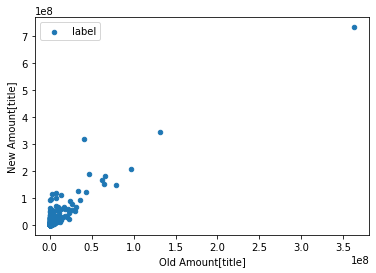

In [8]:
dfCompare=pd.read_excel(os.path.join(cwd_Output,"aacr_dif.xlsx"), engine="openpyxl")
dfCompare=dfCompare[["Gene name","New Amount[title]","Old Amount[title]"]]
dfCompare["dif"]=dfCompare["New Amount[title]"]-dfCompare["Old Amount[title]"]
dfCompare=dfCompare.sort_values(by="dif", ascending=False)
print(dfCompare.head(100))
dfCompare.plot.scatter(x='Old Amount[title]', y='New Amount[title]',label = 'label')
plt.show()

In [7]:
#bonus:all pm IDs with cancer in title
#no longer functions as intended due to a limiter placed on the amount of IDs which can be returned from a single search
url_Pubmed_All_cancer='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=(("cancer"[ti])+AND+(\"+_gene_+\"[ti]))&retmax=100000&retstart='
url_Pubmed_All_cancer = urllib.parse.quote(url_Pubmed_All_cancer, safe="/+?:=&")  # open url and get a copy of the data from the page
RetStart=0
with open(os.path.join(cwd,"cancer_list.txt"), 'w',encoding="utf-8") as f:
    f.write(str("list of all PM UIDs with cancer in title"))
    f.write('\n')
    while RetStart<1200000:
        url_cancer_retstart=str(url_Pubmed_All_cancer)+str(RetStart)
        data_title = urllib.request.urlopen(url_cancer_retstart)
        for line in data_title:
            if str("<Id>") in str(line):
                size = len(line)
                line = line[1:size - 6]
                f.write(str(line))  # write a freeze of the data from the page
                f.write('\n')
        time.sleep(1)
        RetStart+=100000
    f.close()

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=0
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=100000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=200000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=300000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&retstart=400000
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%28%28%22cancer%22%5Bti%5D%29+AND+%28%22+_gene_+%22%5Bti%5D%29%29&retmax=100000&r